# Análise dos dados extraídos no ETL

A análise neste notebook tem como objetivo responder as seguintes perguntas:

1. Número de voos por status (atrasado, no horário, cancelado).
    - Número de voos cancelados.
    - Número de voos com atraso na partida.
    - Número de voos com atraso na chegada.
    - Número de voos que tiveram atraso tanto na partida como na chegada.
    - Número de voos que partiram no horário previsto (quando o horário de partida agendado coincide com o horário de partida real).
2. Aeroporto com o maior número de partidas/chegadas em um período.
    - Aeroporto com o maior número de partidas em horário comercial.
    - Aeroporto com o maior número de chegadas em horário comercial.
3. Tempo médio de atraso dos voos por aeroporto.
    - Tempo médio de atraso na partida dos voos em cada aeroporto.
    - Qual é o aeroporto com o maior atraso médio durante a partida.
    - Tempo médio de atraso na chegada dos voos em cada aeroporto.
    - Qual é o aeroporto com o maior atraso médio durante a chegada.
4. Atrasos por companhia aérea.
    - Quantas voos estão com registrados com nenhuma companhia?
    - Qual é a companhia aérea com o maior número de atrasos na partida?
    - Qual é a companhia aérea com o maior tempo médio de atraso na partida?
    - Qual é a companhia aérea com o maior número de atrasos na chegada?
    - Qual é a companhia aérea com o maior tempo médio de atraso na chegada?
5. Número de voos por hora.
6. Porcentagem de voos para as 10 maiores companhias aéreas.
7. Por onde os aviões estão sobrevoando?

Os gráficos utilizados foram o de barras e o de pizza, para responder às perguntas 5 e 6, respectivamente. Além disso, foi utilizado um mapa para plotar a localização dos aviões em voo, a fim de responder à pergunta 7.

# Insights obtidos

- O horário com maior número de partidas é às 0:00 horas.
    
    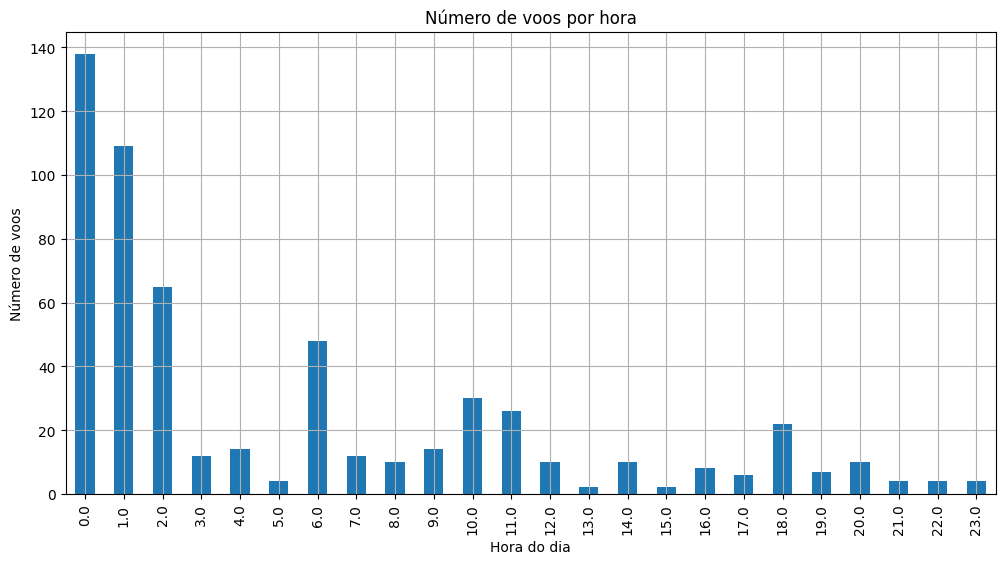

- O aeroporto com o maior número de partidas durante o horário comercial: Logan International com 12 partidas
- O aeroporto com o maior atraso médio é 'Istanbul Airport' com um atraso médio de 248.00 minutos.
- A companhia aérea com o maior número de atrasos na partida é 'Qantas' com 32 atrasos.

## Bibliotecas

In [1]:
%pip install psycopg2-binary


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install folium


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import folium
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

## Carregando os dados em um dataframe

In [7]:
load_dotenv(dotenv_path='../../.env')

False

In [8]:
config_conn = {
    # 'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'host': 'localhost',
    'user': os.getenv('POSTGRES_USER', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD', 'postgres'),
    'database': os.getenv('POSTGRES_DB', 'elt_aviationstack'),
    'port': os.getenv('POSTGRES_PORT', '5432')
}

conn = psycopg2.connect(**config_conn)

df = pd.read_sql_query('SELECT * FROM flights', conn)
conn.close()

/tmp/ipykernel_169016/1972851448.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('SELECT * FROM flights', conn)


In [9]:
df['flight_status'].unique()

array(['scheduled', 'active', 'cancelled', 'landed', 'diverted'],
      dtype=object)

## Número de voos por status (atrasado, no horário, cancelado).

Número de voos cancelados.

In [10]:
df_flight_status_cancelled = df[df['flight_status'] == 'cancelled']
print(f'O total de voos cancelados foi de: {df_flight_status_cancelled.shape[0]}')

O total de voos cancelados foi de: 200


Número de voos com atraso na partida.

In [11]:
df_flight_departure_delay = df[(df['flight_status'] != 'cancelled') & 
                               (df['departure_delay'] > 0)]
print(f'O total de voos com atraso na partida foi de: {df_flight_departure_delay.shape[0]}')

O total de voos com atraso na partida foi de: 473


Número de voos com atraso na chegada.

In [12]:
df_flight_arrival_delay = df[(df['flight_status'] != 'cancelled') & 
                             (df['arrival_delay'] > 0)]
print(f'O total de voos com atraso na chegada foi de: {df_flight_arrival_delay.shape[0]}')

O total de voos com atraso na chegada foi de: 208


Número de voos que tiveram atraso tanto na partida como na chegada.

In [13]:
df_flight_departure_and_arrival_delay = df[(df['flight_status'] != 'cancelled') & 
                                           (df['departure_delay'] > 0) & 
                                           (df['arrival_delay'] > 0)]
print(f'O total de voos com atraso tanto na partida como na chegada foi de: {df_flight_departure_and_arrival_delay.shape[0]}')

O total de voos com atraso tanto na partida como na chegada foi de: 192


Número de voos que partiram no horário previsto (quando o horário de partida agendado coincide com o horário de partida real).

In [14]:
df_flight_on_time = df[(df['flight_status'] != 'cancelled') & 
                       (df['departure_actual'] == df['departure_scheduled'])]
print(f'Números de voos no horário foi de: {df_flight_on_time.shape[0]}')

Números de voos no horário foi de: 12


## Aeroporto com o maior número de partidas/chegadas em um período.

In [15]:
start_time = pd.to_datetime('08:00:00').time()
end_time = pd.to_datetime('18:00:00').time()

df_commercial_hours = df.copy()
df_commercial_hours['departure_time'] = df_commercial_hours['departure_actual'].dt.time
df_commercial_hours['arrival_time'] = df_commercial_hours['arrival_actual'].dt.time

Aeroporto com o maior número de partidas em horário comercial.

In [16]:
df_commercial_hours = df_commercial_hours[(df_commercial_hours['flight_status'] != 'cancelled') &
                                          (df_commercial_hours['departure_time'] >= start_time) & 
                                          (df_commercial_hours['departure_time'] <= end_time)]

departures_count = df_commercial_hours.groupby('departure_airport').size()
most_departures_airport = departures_count.idxmax()
most_departures_count = departures_count.max()
print(f"Aeroporto com o maior número de partidas durante o horário comercial: {most_departures_airport} com {most_departures_count} partidas")

Aeroporto com o maior número de partidas durante o horário comercial: Logan International com 12 partidas


Aeroporto com o maior número de chegadas em horário comercial.

In [17]:
df_commercial_hours = df_commercial_hours[(df_commercial_hours['flight_status'] != 'cancelled') &
                                          (df_commercial_hours['arrival_time'] >= start_time) & 
                                          (df_commercial_hours['arrival_time'] <= end_time)]

arrivals_count = df_commercial_hours.groupby('arrival_airport').size()
most_arrivals_airport = arrivals_count.idxmax()
most_arrivals_count = arrivals_count.max()
print(f"Aeroporto com o maior número de chegadas durante o horário comercial: {most_arrivals_airport} com {most_arrivals_count} partidas")

Aeroporto com o maior número de chegadas durante o horário comercial: Seattle-Tacoma International com 6 partidas


## Tempo médio de atraso dos voos por aeroporto.

Tempo médio de atraso na partida dos voos em cada aeroporto.

In [18]:
df_flight_delay = df.copy()
average_departure_delay_per_airport = df_flight_delay.groupby('departure_airport')['departure_delay'].mean()
average_departure_delay_per_airport = average_departure_delay_per_airport.dropna()
for airport, delay in average_departure_delay_per_airport.items():
    print(f"'{airport}' com um atraso médio de {delay:.2f} minutos")

'Adelaide International Airport' com um atraso médio de 6.67 minutos
'Arvidsjaur' com um atraso médio de 5.00 minutos
'Athens International Airport "Eleftherios Venizelos"' com um atraso médio de 12.00 minutos
'Atlantic City International' com um atraso médio de 2.00 minutos
'Auckland International' com um atraso médio de 8.18 minutos
'Axamo' com um atraso médio de 5.00 minutos
'Baghdad International' com um atraso médio de 6.00 minutos
'Bandar Seri Begwan International Airport' com um atraso médio de 3.00 minutos
'Bar Harbor' com um atraso médio de 6.00 minutos
'Barajas' com um atraso médio de 46.00 minutos
'Beijing Capital International' com um atraso médio de 7.00 minutos
'Beirut Rafic Hariri Airport' com um atraso médio de 27.00 minutos
'Belgrade Nikola Tesla' com um atraso médio de 37.00 minutos
'Ben Gurion International' com um atraso médio de 15.00 minutos
'Biggin Hill' com um atraso médio de 81.00 minutos
'Bodo' com um atraso médio de 7.00 minutos
'Boise Air Terminal/Gowen Fiel

Qual é o aeroporto com o maior atraso médio durante a partida.

In [19]:
max_delay_airport = average_departure_delay_per_airport.idxmax()
max_delay_value = average_departure_delay_per_airport.max()

print(f"O aeroporto com o maior atraso médio é '{max_delay_airport}' com um atraso médio de {max_delay_value:.2f} minutos.")

O aeroporto com o maior atraso médio é 'Istanbul Airport' com um atraso médio de 248.00 minutos.


Tempo médio de atraso na chegada dos voos em cada aeroporto.

In [20]:
df_flight_delay = df.copy()
average_arrival_delay_per_airport = df_flight_delay.groupby('arrival_airport')['arrival_delay'].mean()
average_arrival_delay_per_airport = average_arrival_delay_per_airport.dropna()
for airport, delay in average_arrival_delay_per_airport.items():
    print(f"'{airport}' com um atraso médio de {delay:.2f} minutos")

'Adelaide International Airport' com um atraso médio de 21.17 minutos
'Aeroporto Internacional Guarulhos' com um atraso médio de 502.00 minutos
'Albuquerque International' com um atraso médio de 39.00 minutos
'Auckland International' com um atraso médio de 3.00 minutos
'Beijing Capital International' com um atraso médio de 32.90 minutos
'Beijing Daxing International Airport' com um atraso médio de 43.00 minutos
'Beirut Rafic Hariri Airport' com um atraso médio de 25.00 minutos
'Ben Gurion International' com um atraso médio de 1.00 minutos
'Boise Air Terminal/Gowen Field' com um atraso médio de 4.00 minutos
'Bozeman Yellowstone International Airport' com um atraso médio de 46.00 minutos
'Brisbane International' com um atraso médio de 12.67 minutos
'Cairo International Airport' com um atraso médio de 13.00 minutos
'Cajamarca' com um atraso médio de 22.00 minutos
'Christchurch International' com um atraso médio de 2.00 minutos
'Chu-Bu Centrair International (Central Japan International)' 

Qual é o aeroporto com o maior atraso médio durante a chegada.

In [21]:
max_delay_airport = average_arrival_delay_per_airport.idxmax()
max_delay_value = average_arrival_delay_per_airport.max()

print(f"O aeroporto com o maior atraso médio é '{max_delay_airport}' com um atraso médio de {max_delay_value:.2f} minutos.")

O aeroporto com o maior atraso médio é 'Aeroporto Internacional Guarulhos' com um atraso médio de 502.00 minutos.


## Atrasos por companhia aérea.

Quantas voos estão com registrados com nenhuma companhia?

In [22]:
df_departure_delay = df.copy()

df_departure_delay = df_departure_delay[df_departure_delay['airline_name']=='empty']

print(f'Quantas voos estão com registrados com nenhuma companhia: {df_departure_delay.shape[0]}')

Quantas voos estão com registrados com nenhuma companhia: 45


Qual é a companhia aérea com o maior número de atrasos na partida?

In [23]:
df_departure_delay = df.copy()

df_departure_delay = df_departure_delay[df_departure_delay['airline_name']!='empty']
df_departure_delay['has_departure_delay'] = df_departure_delay['departure_delay'].fillna(0) > 0
delays_by_airline = df_departure_delay[df_departure_delay['has_departure_delay']].groupby('airline_name').size()

max_delays_airline = delays_by_airline.idxmax()
max_delays_count = delays_by_airline.max()

print(f"A companhia aérea com o maior número de atrasos na partida é '{max_delays_airline}' com {max_delays_count} atrasos.")

A companhia aérea com o maior número de atrasos na partida é 'Qantas' com 32 atrasos.


Qual é a companhia aérea com o maior tempo médio de atraso na partida?

In [24]:
df_departure_delay = df.copy()
average_departure_delay_per_airline_name = df_departure_delay.groupby('airline_name')['departure_delay'].mean()
average_departure_delay_per_airline_name = average_departure_delay_per_airline_name.dropna()
max_delay_airline_name = average_departure_delay_per_airline_name.idxmax()
max_delay_value = average_departure_delay_per_airline_name.max()

print(f"A companhia aérea com o maior atraso médio é '{max_delay_airline_name}' com um atraso médio de {max_delay_value:.2f} minutos.")

A companhia aérea com o maior atraso médio é 'Wizz Air' com um atraso médio de 127.00 minutos.


Qual é a companhia aérea com o maior número de atrasos na chegada?

In [25]:
df_arrival_delay = df.copy()

df_arrival_delay = df_arrival_delay[df_arrival_delay['airline_name']!='empty']
df_arrival_delay['has_arrival_delay'] = df_arrival_delay['arrival_delay'].fillna(0) > 0
delays_by_airline = df_arrival_delay[df_arrival_delay['has_arrival_delay']].groupby('airline_name').size()

max_delays_airline = delays_by_airline.idxmax()
max_delays_count = delays_by_airline.max()

print(f"A companhia aérea com o maior número de atrasos na chegada é '{max_delays_airline}' com {max_delays_count} atrasos.")

A companhia aérea com o maior número de atrasos na chegada é 'Qantas' com 22 atrasos.


Qual é a companhia aérea com o maior tempo médio de atraso na chegada?

In [26]:
df_arrival_delay = df.copy()
average_arrival_delay_per_airline_name = df_arrival_delay.groupby('airline_name')['arrival_delay'].mean()
average_arrival_delay_per_airline_name = average_arrival_delay_per_airline_name.dropna()
max_delay_airline_name = average_arrival_delay_per_airline_name.idxmax()
max_delay_value = average_arrival_delay_per_airline_name.max()

print(f"A companhia aérea com o maior atraso médio é '{max_delay_airline_name}' com um atraso médio de {max_delay_value:.2f} minutos.")

A companhia aérea com o maior atraso médio é 'Turkish Airlines' com um atraso médio de 252.00 minutos.


## Número de voos por hora.

In [27]:
df_flights_by_hour = df.copy()
df_flights_by_hour['departure_hour'] = df_flights_by_hour['departure_actual'].dt.hour
flights_by_hour = df_flights_by_hour.groupby('departure_hour').size()

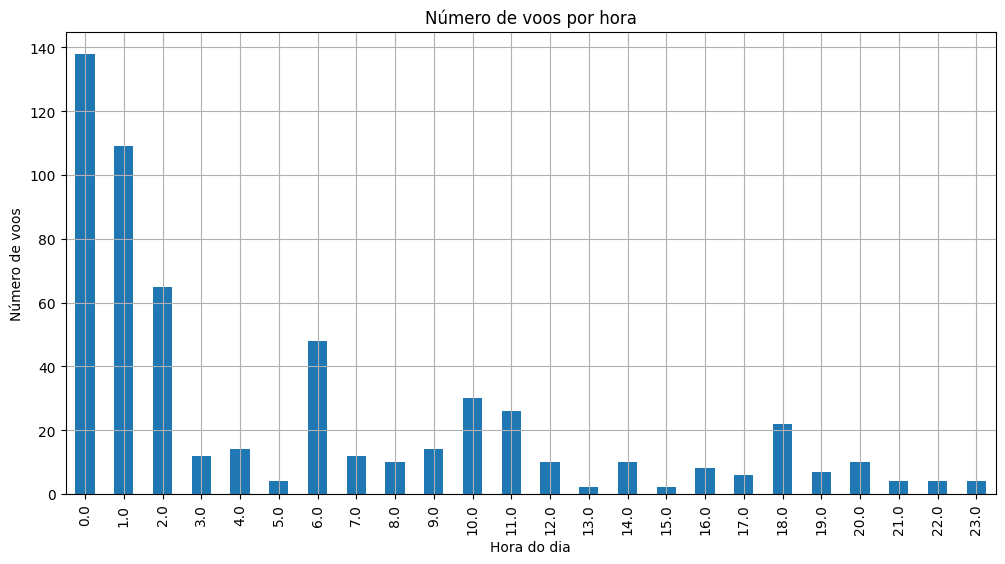

In [28]:
plt.figure(figsize=(12, 6))
flights_by_hour.plot(kind='bar')
plt.title('Número de voos por hora')
plt.xlabel('Hora do dia')
plt.ylabel('Número de voos')
plt.grid(True)
plt.show()

## Porcentagem de voos para as 10 maiores companhias aéreas.

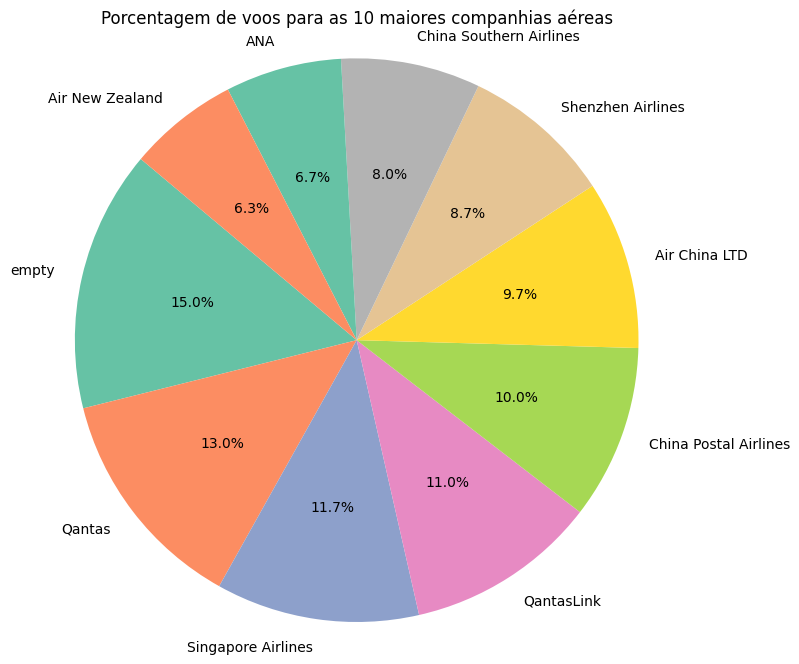

In [29]:
flights_by_airline = df.groupby('airline_name').size()

top_airlines = flights_by_airline.sort_values(ascending=False).head(10)

top_airlines_percentage = (top_airlines / top_airlines.sum()) * 100

plt.figure(figsize=(8, 8))
plt.pie(top_airlines_percentage, labels=top_airlines_percentage.index,
        autopct='%1.1f%%', startangle=140, colors=plt.get_cmap('Set2').colors)
plt.title('Porcentagem de voos para as 10 maiores companhias aéreas')
plt.axis('equal')
plt.show()

## Por onde os aviões estão sobrevoando?

In [30]:
df_flight_with_live_updated = df[df['live_updated'].notna()]

m = folium.Map(location=[df_flight_with_live_updated['live_latitude'].mean(), df_flight_with_live_updated['live_longitude'].mean()], zoom_start=1)

for _, row in df_flight_with_live_updated.iterrows():
    folium.Marker(
        location=[row['live_latitude'], row['live_longitude']],
        # popup=row['location']
    ).add_to(m)

m